# Capstone Project - The Battle of the Neighborhoods (Week 5)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a park. Specifically, this report will be targeted to stakeholders interested in opening an **Park** in **Toronto**, Canada.

Since there are lots of restaurants in Berlin we will try to detect **locations that are not already crowded with parks**. We are also particularly interested in **areas with no parks**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.


## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing parks in the neighborhood.
* number of and distance to parks in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Page Wikipedia**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Toronto city center.

Let's first find the latitude & longitude of Berlin city center, using specific, well known address and Google Maps geocoding API.

In [1]:
!pip install bs4
!pip install shapely
!pip install geocoder
!pip install pyproj

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

import shapely.geometry
import pyproj
import math

from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')

Libraries imported.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Download and Explore Dataset**

Use the Beautiful Soup for extract HTML.

In [3]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url)

Extract Table with Postal Code.

In [4]:
My_table = soup.find('table',{'class':'wikitable sortable'})

**Tranform the data into a pandas dataframe**

In [5]:
Head = My_table.find_all('tr')
Table = []
for th in Head:
    row = np.array(th.getText()[1:-1].split('\n'))
    if row[1] != 'Not assigned': 
        if row[2] == 'Not assigned':
            row[2] = row[1]
        Table.append(row)
        
df_Canada = pd.DataFrame(data=Table[1:], columns=Table[0])
df_Canada.head()

,Postal Code,,Borough,,Neighborhood
0,M1A,,,,Not assigned
1,M2A,,,,Not assigned
2,M3A,,North York,,Parkwoods
3,M4A,,North York,,Victoria Village
4,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"


**Transform Dataset**

In [6]:
Col = df_Canada.columns
df_Canada_Group = df_Canada.groupby(Col[0])[Col[4]].apply(lambda x: ''.join([str(elem+',') for elem in list(x)])).reset_index()
df_Canada_Group.head()

,Postal Code,Neighborhood
0,M1A,"Not assigned,"
1,M1B,"Malvern, Rouge,"
2,M1C,"Rouge Hill, Port Union, Highland Creek,"
3,M1E,"Guildwood, Morningside, West Hill,"
4,M1G,"Woburn,"


Then let's loop through the data and fill the dataframe one row at a time.

In [7]:
df_repeated = df_Canada.sort_values('Postal Code', ascending=True)
df_repeated.drop_duplicates('Postal Code', keep="last", inplace=True)
df_Canada_Group['Borough'] = df_repeated.reset_index()['Borough']
df_Canada_Group.head()

,Postal Code,Neighborhood,Borough
0,M1A,"Not assigned,",
1,M1B,"Malvern, Rouge,",Scarborough
2,M1C,"Rouge Hill, Port Union, Highland Creek,",Scarborough
3,M1E,"Guildwood, Morningside, West Hill,",Scarborough
4,M1G,"Woburn,",Scarborough


# **Geospatial data**

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a wget command and access the data. So let's go ahead and do that.

In [8]:
!wget -q -O 'postal_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


**Load and explore the data**

In [9]:
df_csv = pd.read_csv('postal_data.csv')
df_csv.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df_Canada_Group['Latitude'] = df_csv['Latitude']
df_Canada_Group['Longitude'] = df_csv['Longitude']
df_Canada_Group

,Postal Code,Neighborhood,Borough,Latitude,Longitude
0,M1A,"Not assigned,",,43.806686,-79.194353
1,M1B,"Malvern, Rouge,",Scarborough,43.784535,-79.160497
2,M1C,"Rouge Hill, Port Union, Highland Creek,",Scarborough,43.763573,-79.188711
3,M1E,"Guildwood, Morningside, West Hill,",Scarborough,43.770992,-79.216917
4,M1G,"Woburn,",Scarborough,43.773136,-79.239476
5,M1H,"Cedarbrae,",Scarborough,43.744734,-79.239476
6,M1J,"Scarborough Village,",Scarborough,43.727929,-79.262029
7,M1K,"Kennedy Park, Ionview, East Birchmount Park,",Scarborough,43.711112,-79.284577
8,M1L,"Golden Mile, Clairlea, Oakridge,",Scarborough,43.716316,-79.239476
9,M1M,"Cliffside, Cliffcrest, Scarborough Village West,",Scarborough,43.692657,-79.264848


# **Visualization**

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent tr_explorer, as shown below.

In [11]:
address = 'downtown,Toronto'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6541737, -79.38081164513409.


In [12]:
toronto_data = df_Canada_Group[df_Canada_Group['Neighborhood'] != 'Not assigned,'].reset_index(drop=True)
toronto_data1 = toronto_data.dropna()
toronto_data1

,Postal Code,Neighborhood,Borough,Latitude,Longitude
0,M1B,"Malvern, Rouge,",Scarborough,43.784535,-79.160497
1,M1C,"Rouge Hill, Port Union, Highland Creek,",Scarborough,43.763573,-79.188711
2,M1E,"Guildwood, Morningside, West Hill,",Scarborough,43.770992,-79.216917
3,M1G,"Woburn,",Scarborough,43.773136,-79.239476
4,M1H,"Cedarbrae,",Scarborough,43.744734,-79.239476
5,M1J,"Scarborough Village,",Scarborough,43.727929,-79.262029
6,M1K,"Kennedy Park, Ionview, East Birchmount Park,",Scarborough,43.711112,-79.284577
7,M1L,"Golden Mile, Clairlea, Oakridge,",Scarborough,43.716316,-79.239476
8,M1M,"Cliffside, Cliffcrest, Scarborough Village West,",Scarborough,43.692657,-79.264848
9,M1N,"Birch Cliff, Cliffside West,",Scarborough,43.757410,-79.273304


In [13]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data1['Latitude'], toronto_data1['Longitude'], toronto_data1['Borough'], toronto_data1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Folium is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Let's get the geographical coordinates of DownTown.

In [14]:
address = 'Downtown,Toronto'

geolocator = Nominatim(user_agent="sb_explorer")
location = geolocator.geocode(address)
latitude_Center = location.latitude
longitude_Center = location.longitude
print('The geograpical coordinate of DownTown are {}, {}.'.format(latitude_Center, longitude_Center))

The geograpical coordinate of DownTown are 43.6541737, -79.38081164513409.


As we did with all of DownTown, let's visualizat DownTown the neighborhoods in it.

In [15]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(map_toronto)
map_toronto

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.

In [16]:
Downtown_data = df_Canada_Group[df_Canada_Group['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
Downtown_data.head()

,Postal Code,Neighborhood,Borough,Latitude,Longitude
0,M4W,"Rosedale,",Downtown Toronto,43.669005,-79.442259
1,M4X,"St. James Town, Cabbagetown,",Downtown Toronto,43.647927,-79.419750
2,M4Y,"Church and Wellesley,",Downtown Toronto,43.636847,-79.428191
3,M5A,"Regent Park, Harbourfront,",Downtown Toronto,43.691116,-79.476013
4,M5B,"Garden District, Ryerson,",Downtown Toronto,43.673185,-79.487262


In [17]:
# define the dataframe columns
column_names = ['Postal Code', 'Borough', 'Neighborhood','Latitude','Longitude']

# instantiate the dataframe
neighborhoods_Downtown = pd.DataFrame(columns=column_names)

# Iteración por filas del DataFrame:
for idx_row, row in Downtown_data.iterrows():
    Postal_Code = row[0]
    Borough = row[2]
    Latitude = row[3]
    Longitude = row[4]
    for Neighborhood in row[1].split(','):
        if Neighborhood !='':
            neighborhoods_Downtown = neighborhoods_Downtown.append({'Postal Code':Postal_Code,'Borough':Borough,'Neighborhood':Neighborhood,
                                                            'Latitude':Latitude,'Longitude':Longitude}, ignore_index=True)
neighborhoods_Downtown.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.669005,-79.442259
1,M4X,Downtown Toronto,St. James Town,43.647927,-79.419750
2,M4X,Downtown Toronto,Cabbagetown,43.647927,-79.419750
3,M4Y,Downtown Toronto,Church and Wellesley,43.636847,-79.428191
4,M5A,Downtown Toronto,Regent Park,43.691116,-79.476013


Correct neighborhood location (Latitude and Longitude)

In [18]:
Changes = [('Stn A PO Boxes 25 The Esplanade','Toronto Station'),
           ('Underground city','Queen'),
           ('Richmond','Richmond St W'),
           ('South Niagara','Niagara'),
           ('Railway Lands','108-120 Front St W')]
for change in Changes:
    neighborhoods_Downtown.loc[neighborhoods_Downtown.loc[:, 'Neighborhood']==change[0],'Neighborhood'] = change[1]
    print(' .', end='')
print(' Correction done.')
# 
# Downtown_data = toronto_data.dropna()
# Downtown_data

Downtown_data = neighborhoods_Downtown.dropna()
toronto_data = Downtown_data[Downtown_data['Neighborhood'] != 'Stn A PO Boxes'].reset_index(drop=True)
toronto_data

 . . . . . Correction done.


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.669005,-79.442259
1,M4X,Downtown Toronto,St. James Town,43.647927,-79.419750
2,M4X,Downtown Toronto,Cabbagetown,43.647927,-79.419750
3,M4Y,Downtown Toronto,Church and Wellesley,43.636847,-79.428191
4,M5A,Downtown Toronto,Regent Park,43.691116,-79.476013
5,M5A,Downtown Toronto,Harbourfront,43.691116,-79.476013
6,M5B,Downtown Toronto,Garden District,43.673185,-79.487262
7,M5B,Downtown Toronto,Ryerson,43.673185,-79.487262
8,M5C,Downtown Toronto,St. James Town,43.661608,-79.464763
9,M5E,Downtown Toronto,Berczy Park,43.648960,-79.456325


In [19]:
# Iteración por filas del DataFrame:
for idx_row, row in toronto_data.iterrows():
    address = str(row[2])+',Toronto'
    geolocator = Nominatim(user_agent="sb_explorer")
    location = geolocator.geocode(address)
    toronto_data.loc[idx_row,'Latitude'] = location.latitude
    toronto_data.loc[idx_row,'Longitude'] = location.longitude

As we did with all of Scarborough, let's visualizate Downtown the neighborhoods in it.

In [20]:
map_Downtown = folium.Map(location=[latitude_Center, longitude_Center], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Downtown_data['Latitude'], Downtown_data['Longitude'], Downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown)  
    
map_Downtown

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Toronto that have low parks density, particularly those with low number of parks. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every park within 6km from Toronto center** (Alexanderplatz). We have also **identified parks** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**park density**' across different areas of Toronto - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general (*and* no parks in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two parks in radius of 250 meters**, and we want locations **without parks in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Define Foursquare Credentials and Versio

In [21]:
CLIENT_ID = '3CU31MEK1COG5ND15MTGT2O0SWSUV5TTEBDRO4ME5IVVNDHB' # your Foursquare ID
CLIENT_SECRET = 'VECWVZNJA0ONZHX3ZD2TGDGJ1PLDWGX34A1AOFEIEUXPD11P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3CU31MEK1COG5ND15MTGT2O0SWSUV5TTEBDRO4ME5IVVNDHB
CLIENT_SECRET:VECWVZNJA0ONZHX3ZD2TGDGJ1PLDWGX34A1AOFEIEUXPD11P


**Explore Neighborhoods in Downtown Toronto**


Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,search_query=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       #print(name)
        print(' .', end='')    
        # create the API request URL
        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            lat, 
            lng, 
            radius, 
            20)
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
QUERY = 'Store'
Downtown_venues = getNearbyVenues(names=Downtown_data['Neighborhood'],
                                   latitudes=Downtown_data['Latitude'],
                                   longitudes=Downtown_data['Longitude'],
                                   search_query=QUERY
                                  )

print(' done.')

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


Now write the code to run the above function on each neighborhood and create a new dataframe called Downtown_venues

In [24]:
print(Downtown_venues.shape)
Downtown_venues.head()

(78, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.669005,-79.442259,FreshCo,43.667918,-79.440754,Grocery Store
1,Rosedale,43.669005,-79.442259,Rexall,43.667504,-79.442086,Pharmacy
2,Rosedale,43.669005,-79.442259,Galleria Shopping Centre,43.667592,-79.442053,Shopping Mall
3,Rosedale,43.669005,-79.442259,LCBO,43.667002,-79.441747,Liquor Store
4,St. James Town,43.647927,-79.419750,Lost & Found,43.649378,-79.424149,Men's Store


In [25]:
def generateBaseMap(default_location=[latitude_Center, longitude_Center], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

Downtown_venues['count'] = 1
DowntownHeat_map = generateBaseMap()
data_HeatMap = Downtown_venues[['Venue Latitude', 'Venue Longitude', 'count']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data_HeatMap, radius=9, max_zoom=13).add_to(DowntownHeat_map)

In [26]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(DowntownHeat_map)
DowntownHeat_map

In [27]:
DowntownHeat_map_Locations = DowntownHeat_map
DowntownHeat_map_Locations.add_child(folium.ClickForMarker(popup='Potential Location'))

# **Analyze Each Neighborhood**

In [28]:
# one hot encoding
Downtown_onehot = pd.get_dummies(Downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Downtown_onehot['Neighborhood'] = Downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Downtown_onehot.columns[-1]] + list(Downtown_onehot.columns[:-1])
Downtown_onehot = Downtown_onehot[fixed_columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
Downtown_grouped = Downtown_onehot.groupby('Neighborhood').mean().reset_index()
Downtown_grouped.head()

,Neighborhood,Arts & Crafts Store,Bar,Beer Store,Bookstore,Boutique,Café,Clothing Store,Comic Shop,Convenience Store,Cuban Restaurant,Department Store,Discount Store,Furniture / Home Store,Gourmet Shop,Grocery Store,Hobby Shop,Japanese Restaurant,Liquor Store,Men's Store,Miscellaneous Shop,Pharmacy,Shopping Mall,Smoothie Shop,Sporting Goods Shop,Supermarket
0,Adelaide,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.111111,0.0,0.111111,0.111111,0.0,0.0,0.111111,0.111111,0.0,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111
1,Bathurst Quay,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,Cabbagetown,0.0,0.1,0.0,0.0,0.200000,0.1,0.1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.100000,0.3,0.1,0.0,0.000000,0.0,0.0,0.000000
3,Design Exchange,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Harbourfront West,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    shop_places = row_categories_sorted.index.values[0:num_top_venues]
    for counter in range(len(shop_places)):
       shop_places[counter] = shop_places[counter] + ' (' + str(row_categories_sorted[counter]*100) + '%)'
    
    return shop_places

In [31]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_grouped['Neighborhood']

for ind in np.arange(Downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,Supermarket (11.11111111111111%),Convenience Store (11.11111111111111%),Shopping Mall (11.11111111111111%),Boutique (11.11111111111111%),Liquor Store (11.11111111111111%)
1,Bathurst Quay,Beer Store (50.0%),Liquor Store (50.0%),Supermarket (0.0%),Discount Store (0.0%),Bar (0.0%)
2,Cabbagetown,Men's Store (30.0%),Boutique (20.0%),Bar (10.0%),Miscellaneous Shop (10.0%),Liquor Store (10.0%)
3,Design Exchange,Comic Shop (100.0%),Supermarket (0.0%),Discount Store (0.0%),Bar (0.0%),Beer Store (0.0%)
4,Harbourfront West,Beer Store (50.0%),Liquor Store (50.0%),Supermarket (0.0%),Discount Store (0.0%),Bar (0.0%)


Let's perform some basic exploratory data analysis and derive some additional info from our raw data. First let's count the number of stores in every area candidate:

Now we only look at the electronic stores, so a calorie map will be plotted to visualize in the areas that there are more electronic stores (Direct Competition) and thus be able to choose the area correctly.

# **Explore Neighborhoods in Downtown Toronto (Parks)**

In [32]:
QUERY = 'Parks'

Downtown_venues_park = getNearbyVenues(names=Downtown_data['Neighborhood'],
                                   latitudes=Downtown_data['Latitude'],
                                   longitudes=Downtown_data['Longitude'],
                                   search_query=QUERY
                                  )

print(' done.')

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [33]:
print(Downtown_venues_park.shape)
Downtown_venues_park.head()

(49, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.669005,-79.442259,Wallace Emerson Park,43.666933,-79.439449,Park
1,Rosedale,43.669005,-79.442259,Chandos Park North,43.670900,-79.442400,Park
2,Rosedale,43.669005,-79.442259,Brandon Avenue Parkette,43.670486,-79.440048,Park
3,Rosedale,43.669005,-79.442259,Beaver Lightbourn Parkette,43.671400,-79.443500,Park
4,Rosedale,43.669005,-79.442259,Bristol Avenue Parkette,43.670700,-79.438498,Park



**Heat map for parks in downtown toronto**

A heat map is a two-dimensional representation of data in which the values are represented by colors. A heat map provides a visual summary of the information we want to represent. Thus heat maps allow to understand quite complex data sets.

In [34]:
Downtown_venues_park['Parks'] = 1
DowntownHeat_map = generateBaseMap()
data_HeatMap = Downtown_venues_park[['Venue Latitude', 'Venue Longitude', 'Parks']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data_HeatMap, radius=11, max_zoom=9).add_to(DowntownHeat_map)

In [35]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(DowntownHeat_map)
DowntownHeat_map

In [36]:
DowntownHeat_map_Locations = DowntownHeat_map
DowntownHeat_map_Locations.add_child(folium.ClickForMarker(popup='Potential Location'))

In [37]:
DowTown_Neig = Downtown_venues_park[['Neighborhood','Venue', 'Venue Category', 'Parks']]
DowTown_Neig = DowTown_Neig[DowTown_Neig['Venue Category'] == 'Park']
DowTown_Neig = DowTown_Neig.groupby(['Neighborhood']).sum().reset_index()


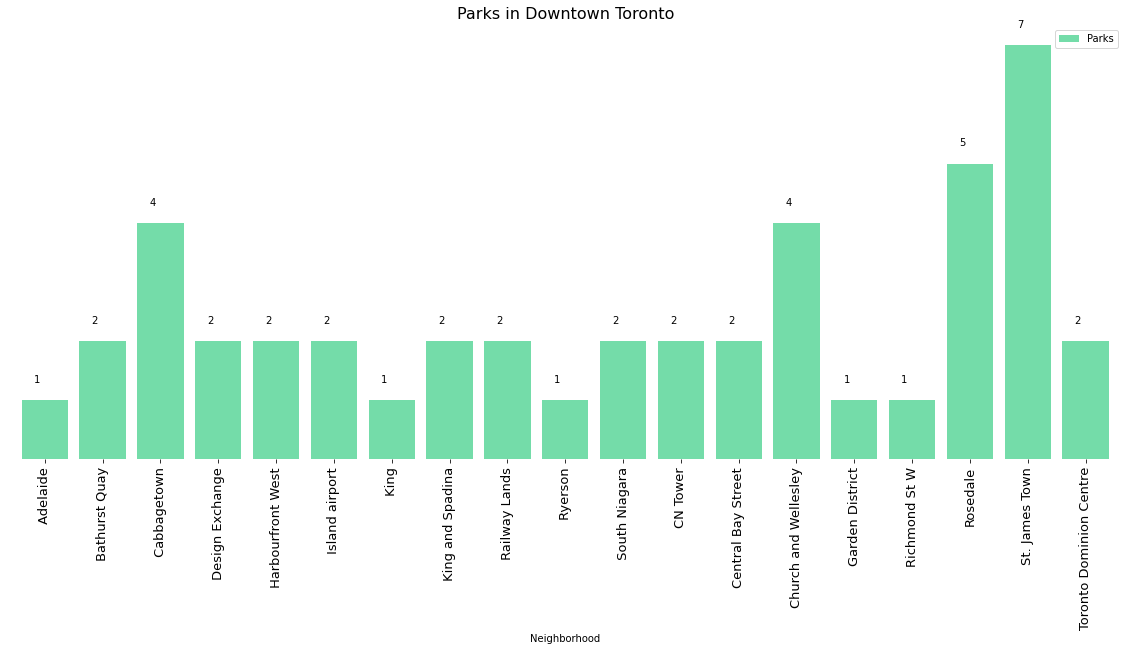

In [38]:
DowTown_Neig.index = DowTown_Neig['Neighborhood']

ax = DowTown_Neig.plot(kind='bar', figsize=(20, 8),width=0.8,color=('#74DCA9'),grid=False)
# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_yaxis().set_visible(False)
ax.set_facecolor('#FFFFFF')
plt.title('Parks in Downtown Toronto',fontsize=16) # add title to the plot


plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:}'.format(height), (x+0.212, y + height+0.3))
plt.show()

In [39]:
# create map of Toronto using latitude and longitude values

# add markers to map
for lat, lng, label in zip(Downtown_data['Latitude'], Downtown_data['Longitude'], Downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(DowntownHeat_map)  
    
DowntownHeat_map

# **Results and Discussion**

Our analysis shows that, although there are many electronics stores in Toronto (in our area of ​​initial interest, which was 12x12 km around downtown Toronto), there are pockets of low-density parks quite close to the city center. . The highest concentration of parks was detected in the south of downtown Toronto, so we focus our attention on the west, southeast, east and southwest areas, which correspond to the Rosedale, Niagara and Toronto Station districts. Another district was identified as potentially interesting (CN Tower, south of the city center), but we focus on Rosedale and Niagara, which offer a combination of popularity among tourists, proximity to the city center, strong socio-economic dynamics and A number of stores low density pockets.

After directing our attention to this narrowest area of ​​interest (covering approximately 5x5 km south of the center), restaurants were first obtained near the center; those locations were filtered so that those with more than two stores within a radius of 150 m and those with an electronic store within 500 m were removed.

Those placement candidates were grouped together to create areas of interest that contain the largest number of placement candidates. The addresses of the centers in those areas were also generated using reverse geocoding to be used as markers / starting points for a more detailed local analysis based on other factors.

The result of all this is 6 zones that contain the greatest number of potential locations of new stores, depending on the number and distance to existing places, both stores in general and parks in particular. This, of course, does not imply that these areas are really optimal locations for a new park! The purpose of this analysis was to provide information only on areas close to the center of Toronto but not full of existing stores (particularly electronic stores); It is quite possible that there is a very good reason for a small number of stores in any of those areas, reasons that would make them unsuitable for a new store, regardless of the lack of competition in the area. Therefore, the recommended areas should be considered only as a starting point for a more detailed analysis that could eventually result in a location that not only does not have close competition, but also other factors taken into account and all other relevant conditions compliments. It is also seen that much of downtown Toronto is saturated with stores in general.

# **Conclusion**

The objective of this project was to identify the areas of Toronto near the center with a low number of stores and particularly parks to help interested parties reduce the search for an optimal location for a new park; When calculating store density distribution from Foursquare data, we first identify general districts that warrant additional analysis (Rosedale and Niagara), and then generate a wide collection of locations that meet some basic requirements with respect to existing nearby parks . The grouping of these locations was then carried out to create the main areas of interest (containing the greatest number of potential locations) and the addresses of those zone centers were created to be used as starting points for the final exploration by the interested.

Interested parties will make the final decision on the optimal location of the store based on the specific characteristics of the neighborhoods and locations in each recommended area, taking into account additional factors such as the attractiveness of each location (proximity to the park or water), noise levels / proximity to main roads, availability of real estate, prices, social and economic dynamics of each neighborhood, etc.